In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.vit import ViT
from torchvision import transforms

# Setting

In [114]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

In [69]:
artifact_path = Path("../../artifacts/vit")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/animal10")

In [70]:
device = torch.device("cuda:0")

# data

In [71]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

In [72]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [73]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [74]:
num_class = len(dataset.classes)

# model

In [75]:
DOWNSCALE_FACTOR = 4

In [76]:
model = ViT(
    output_size=num_class,
    image_size=IMAGE_SIZE,
    # which is 16x16, I write calculation explicitly for flexibility. you can just assign 16
    patch_size=IMAGE_SIZE // 14,
    # 4 times smaller than base
    embed_dim=768 // DOWNSCALE_FACTOR,  
    hidden_dim=3072 // DOWNSCALE_FACTOR,
    num_head=12,  # same as base
    num_encoder_layers=12,
    # size="base", # too large
).to(device)

In [77]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
ViT                                                               --
├─ModuleDict: 1-1                                                 --
│    └─PositionEncoding1d: 2-1                                    37,824
│    └─ClassEmbedding: 2-2                                        192
│    └─Sequential: 2-3                                            --
│    │    └─Conv2d: 3-1                                           147,648
│    │    └─Flatten: 3-2                                          --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-4                                            --
│    │    └─TransformerEncoderLayer: 3-3                          444,864
│    │    └─TransformerEncoderLayer: 3-4                          444,864
│    │    └─TransformerEncoderLayer: 3-5                          444,864
│    │    └─TransformerEncoderLayer: 3-6                          444,864

# training

In [115]:
epoches = 30

In [116]:
trainer = ClassificationTrainer(epoches, device)

In [117]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) # TODO: try lr and lambda

In [81]:
recorder = TrainRecorder(total_epoch=epoches)
recorder.increment_data_size(len(dataset))

In [82]:
scaler = torch.cuda.amp.GradScaler()

In [83]:
_ = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 204/204 [01:40<00:00,  2.03it/s]


Epoch 1 : 0.018760656289563617 (0%)


100%|██████████| 204/204 [01:43<00:00,  1.97it/s]


Epoch 2 : 0.01608524144372044 (-14%)


100%|██████████| 204/204 [01:40<00:00,  2.04it/s]


Epoch 3 : 0.014693048335573394 (-9%)


100%|██████████| 204/204 [01:39<00:00,  2.05it/s]


Epoch 4 : 0.013861539534257642 (-6%)


100%|██████████| 204/204 [01:38<00:00,  2.07it/s]


Epoch 5 : 0.013006080776581655 (-6%)


100%|██████████| 204/204 [01:38<00:00,  2.08it/s]


Epoch 6 : 0.012289799108075018 (-6%)


100%|██████████| 204/204 [01:38<00:00,  2.06it/s]


Epoch 7 : 0.011664557677365555 (-5%)


100%|██████████| 204/204 [01:38<00:00,  2.07it/s]


Epoch 8 : 0.01132432074965565 (-3%)


100%|██████████| 204/204 [01:38<00:00,  2.06it/s]


Epoch 9 : 0.010822210220270747 (-4%)


100%|██████████| 204/204 [01:37<00:00,  2.08it/s]


Epoch 10 : 0.010554337475114873 (-2%)


100%|██████████| 204/204 [01:47<00:00,  1.89it/s]


Epoch 11 : 0.010103954246662635 (-4%)


100%|██████████| 204/204 [01:40<00:00,  2.02it/s]


Epoch 12 : 0.009883195768589686 (-2%)


100%|██████████| 204/204 [01:39<00:00,  2.05it/s]


Epoch 13 : 0.009634317754856741 (-3%)


100%|██████████| 204/204 [01:39<00:00,  2.04it/s]


Epoch 14 : 0.009416977747397661 (-2%)


100%|██████████| 204/204 [01:39<00:00,  2.05it/s]


Epoch 15 : 0.009298159716496236 (-1%)


100%|██████████| 204/204 [01:40<00:00,  2.04it/s]


Epoch 16 : 0.00899763791754838 (-3%)


100%|██████████| 204/204 [01:45<00:00,  1.93it/s]


Epoch 17 : 0.008788406170417687 (-2%)


100%|██████████| 204/204 [01:39<00:00,  2.06it/s]


Epoch 18 : 0.00871271514752326 (-1%)


100%|██████████| 204/204 [01:37<00:00,  2.09it/s]


Epoch 19 : 0.008497547855615439 (-2%)


100%|██████████| 204/204 [01:38<00:00,  2.07it/s]


Epoch 20 : 0.008348874193064976 (-2%)


100%|██████████| 204/204 [01:47<00:00,  1.89it/s]


Epoch 21 : 0.008137859659374538 (-3%)


100%|██████████| 204/204 [01:52<00:00,  1.81it/s]


Epoch 22 : 0.007941272268412231 (-2%)


100%|██████████| 204/204 [01:48<00:00,  1.87it/s]


Epoch 23 : 0.00781678765246045 (-2%)


100%|██████████| 204/204 [01:40<00:00,  2.03it/s]


Epoch 24 : 0.007674275635716713 (-2%)


100%|██████████| 204/204 [01:49<00:00,  1.87it/s]


Epoch 25 : 0.007506418416669399 (-2%)


100%|██████████| 204/204 [01:51<00:00,  1.84it/s]


Epoch 26 : 0.007413470664032188 (-1%)


100%|██████████| 204/204 [01:44<00:00,  1.94it/s]


Epoch 27 : 0.007207988103473654 (-3%)


100%|██████████| 204/204 [01:39<00:00,  2.06it/s]


Epoch 28 : 0.00711159059228077 (-1%)


100%|██████████| 204/204 [01:38<00:00,  2.06it/s]


Epoch 29 : 0.00694667721974977 (-2%)


100%|██████████| 204/204 [01:38<00:00,  2.08it/s]

Epoch 30 : 0.006864001754680017 (-1%)


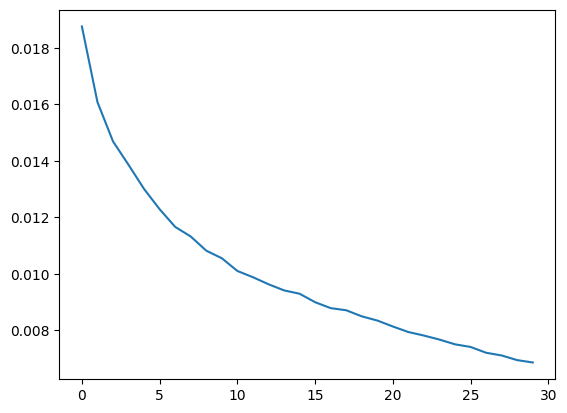

In [84]:
plt.plot(recorder.training_losses[0])

# inference

In [118]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
])

In [119]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [120]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [121]:
evaluator = ClassificationEvaluator(num_class, device)

In [122]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 205/205 [01:32<00:00,  2.22it/s]

[[3571  186  116   49   86  236  142  168  197  112]
 [ 165 1889  123   12   33   36  210   65   49   41]
 [  58   57 1121    3    9   42   27   32   64   33]
 [  74   15    1 1735   19   35    2   18  163   50]
 [ 215   59   27   32 2435   64   22   51   97   96]
 [ 563   20   32   24   18  760   15   25  130   81]
 [ 119  243  106    6   14   22 1104  193   31   28]
 [ 106   72   82    4   30   45  130 1257   77   17]
 [ 165   22   25  221   22   95   11   25 4138   97]
 [ 164   18   35   52   20  128   15   33  208 1189]]


In [123]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.734320378367263
cavallo   : 0.7201677468547465
elefante  : 0.7752420470262794
farfalla  : 0.8214962121212122
gallina   : 0.7859909619109102
gatto     : 0.4556354916067146
mucca     : 0.5916398713826366
pecora    : 0.6906593406593406
ragno     : 0.8583281476872018
scoiattolo: 0.6385606874328679


In [124]:
per_class_acc.mean()

0.7072040885049173

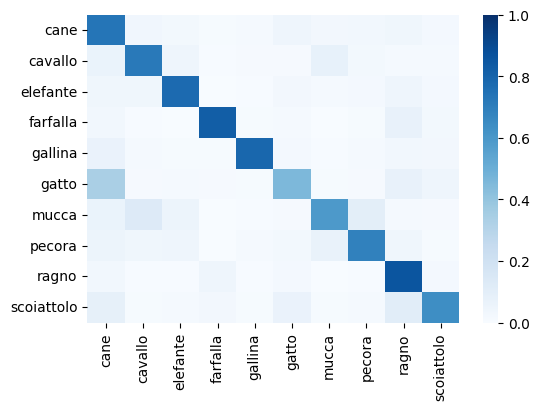

In [125]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [108]:
from torchlake.common.controller.weight_manager import WeightManager

In [109]:
manager = WeightManager(artifact_path.joinpath("vit.{dim}.{psize}x{psize}.pth").as_posix())

In [110]:
model_path = manager.get_filename(dim=model.embed_dim, psize=model.patch_size)

In [111]:
model_path

WindowsPath('../../artifacts/vit/vit.192.16x16.pth')

In [112]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\vit\vit.192.16x16.pth, model size is 21.13MiB


In [113]:
manager.load_weight(model_path, model)